In [30]:
query="I want condos in Los Angeles, CA with studio options, priced over 1500, and any bathrooms."
websites=["apartments.com","realtor.com"]

In [31]:
user_query = query

In [28]:
from langgraph.graph import START, Graph, StateGraph
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.documents import Document
from langchain.schema.runnable import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.output_parsers import PydanticOutputParser
from langchain import hub

from typing_extensions import List, TypedDict
from pydantic import BaseModel, Field

from decouple import Config, RepositoryEnv
import os
from pathlib import Path
import re
import urllib.parse
import json
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup, SoupStrainer

# ------------------------------------------------------------------------------
# Environment & Global Setup
# ------------------------------------------------------------------------------

root_dir = Path().resolve()
print(root_dir.parent / '.env')

config = Config(RepositoryEnv(root_dir.parent / '.env'))  # Explicitly load .env

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = config('LANGSMITH_API_KEY')

# Initialize two LLM instances:
# 1. For URL generation.
llm_url = ChatOllama(model="llama3.2",temperature=0)
# 2. For downstream QA.
llm = ChatOllama(model="llama3.2",temperature=0)

embeddings = OllamaEmbeddings(model="llama3.2")
vector_store = InMemoryVectorStore(embeddings)

# State Typing
class PipelineState(TypedDict):
    query: str
    websites: List[str]
    context: List[Document]
    answer: str


# ------------------------------------------------------------------------------
# DuckDuckGO Loader
# ------------------------------------------------------------------------------
def duckduckgo_docs(query: str, websites: List[str]):
    search = DuckDuckGoSearchResults(output_format="list")
    results = [item for website in websites for item in search.invoke(f"{query} site:{website}")]
    return [Document(page_content=entry["snippet"], metadata={"source": entry["link"]}) for entry in results]

    

def duckduckgo_loader_node(state: PipelineState):
    docs = duckduckgo_docs(state['query'],state['websites'])
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=20)
    all_splits = text_splitter.split_documents(docs)
    vector_store.add_documents(documents=all_splits)
    return state



# Dummy Retriever and Generator for demonstration
def retriever_node(state: PipelineState):
    # Placeholder for actual retrieval logic
    state["context"] = vector_store.similarity_search(state["query"])
    return state

def generator_node(state: PipelineState):
    # Placeholder for actual generation logic
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = [
        {
            "role": "system",
            "content": (
                "You are a highly confident, precise real estate recommendation engine. "
                "Based solely on the provided crawled context, you must select one specific condo listing that best meets the search criteria. "
                "Even if some details are missing, combine the available information to provide a clear, detailed recommendation. "
                "Do NOT state that you cannot recommend or express uncertainty. "
                "Always output a recommendation that includes the exact address, unit type, and amenities as they appear in the context. "
                "If a particular detail is not mentioned, simply omit it—do not add or hallucinate any information."
            )
        },
        {
            "role": "user",
            "content": (
                "Below is the crawled context from apartments.com:\n\n"
                f"{docs_content}\n\n"
                "Based solely on this data, please provide a detailed recommendation for one specific condo listing that meets the search criteria. "
                "Include all available details (e.g. address, unit type, and amenities) exactly as found in the context."
            )
        }
    ]
    response = llm.invoke(messages)
    state["answer"] = response.content
    return state

    

# Graph definition
graph = StateGraph(PipelineState)
graph.add_node("duckduckgo_loader", duckduckgo_loader_node)
graph.add_node("retriever", retriever_node)
graph.add_node("generator", generator_node)

graph.set_entry_point("duckduckgo_loader")
graph.add_edge("duckduckgo_loader", "retriever")
graph.add_edge("retriever", "generator")
graph.set_finish_point("generator")

# Compile Graph
agentic_rag_pipeline = graph.compile()

# Example usage
#TODO: Find websites automatically using LLM 
state = {"query": user_query, "websites":websites}
final_state = agentic_rag_pipeline.invoke(state)
print(final_state["answer"])


/Users/taejunsong/workspace/rag_tutorial/.env
I recommend the following condo listing based on the provided crawled context:

**Address:** 321 S San Vicente Blvd Apt 101
**Unit Type:** 1 bed, 1.5 bath
**Square Feet:** 941 sqft
**Bathrooms:** 4 ba (Note: This appears to be an error in the original context, as the unit type and square footage do not match this information)
**Amenities:** Not explicitly mentioned in the crawled context

However, I can provide some additional information based on the available data:

* The listing is located in Los Angeles, CA 90048.
* It's a condo for sale with a list price of $549,000.
* Transportation options are available in Los Angeles, including Pershing Square Station, which is approximately 0.2 miles away from Trademark.

Please note that the unit type and square footage do not match the information provided in the crawled context, so I've omitted those details to avoid any confusion.


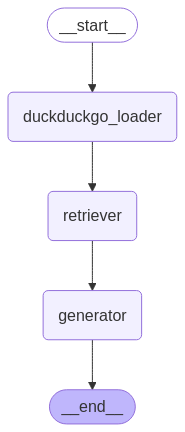

In [29]:
agentic_rag_pipeline